In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!nvidia-smi

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
data1 = pd.read_csv('/kaggle/input/divided/reduced_memory_first_part.csv')
data1 = data1.drop(columns=['Unnamed: 0', 'monthly_sales', 'date', 'item_cnt_day'])
data1 = reduce_mem_usage(data1)

Memory usage after optimization is: 264.90 MB
Decreased by 83.5%


In [5]:
data2 = pd.read_csv('/kaggle/input/divided/reduced_memory_second_part.csv')
data2= data2.drop(columns=['Unnamed: 0', 'monthly_sales', 'date', 'item_cnt_day'])
data2 = reduce_mem_usage(data2)

Memory usage after optimization is: 273.99 MB
Decreased by 81.5%


In [6]:
data = pd.concat([data1, data2])
del data1, data2

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class ModelValidator:
    def __init__(self, train, dev, target_name):
        self.train_x = train.drop([target_name], axis=1) 
        self.train_y = train[target_name]
        
        self.dev_x = dev.drop([target_name], axis=1)
        self.dev_y = dev[target_name]
        
        self.model = None

    def get_model(self):
        return self.model
    
    def get_dev(self):
        return self.dev_x, self.dev_y
    
    def get_train(self):
        return self.train_x, self.train_y

    
    def set_model(self, model_name):
        if model_name == 'xgbr':
            import gc
            import pickle
            from xgboost import XGBRegressor
            from matplotlib.pylab import rcParams
            self.model = XGBRegressor(max_depth=4,n_estimators=10)
    
    def train_model(self):
        self.model.fit(self.train_x,self.train_y,eval_metric="rmse")
        y_pred = self.model.predict(self.dev_x)
        print(f'\nMSE : {mean_squared_error(self.dev_y, y_pred)}\nMAE : {mean_absolute_error(self.dev_y, y_pred)}\n R2 : {r2_score(self.dev_y, y_pred)}')

In [8]:
mv = ModelValidator(data[data.date_block_num<=32], data[(data.date_block_num>32)&(data.date_block_num<=33)], 'item_cnt_month')
kaggle = data[data.date_block_num==34].drop(['item_cnt_month'], axis=1)

train_x, train_y = mv.get_train()
test_x, test_y = mv.get_dev()
del data

### Feature importance

In [9]:
def plot_feature_importance_layer(model, train_x, name):
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    feature_importances_df = pd.DataFrame({'feature': train_x.columns[sorted_idx], 'importance': feature_importances[sorted_idx]})
    plt.figure(figsize=(15, 10))
    sns.barplot(x='importance', y='feature', data=feature_importances_df)
    plt.title(name)
    plt.show()

#### Before optimization

In [10]:
#XGBoost
import xgboost as xgb
xgbr = xgb.XGBRegressor(tree_method='gpu_hist')
xgbr.fit(train_x, train_y)

#Catboost
from catboost import CatBoostRegressor
catboostR = CatBoostRegressor(task_type='GPU')
catboostR.fit(train_x, train_y)

Learning rate set to 0.143246
0:	learn: 2.6045223	total: 145ms	remaining: 2m 24s
1:	learn: 2.4702409	total: 276ms	remaining: 2m 17s
2:	learn: 2.3603010	total: 441ms	remaining: 2m 26s
3:	learn: 2.2709944	total: 563ms	remaining: 2m 20s
4:	learn: 2.1970138	total: 695ms	remaining: 2m 18s
5:	learn: 2.1425811	total: 848ms	remaining: 2m 20s
6:	learn: 2.0923062	total: 963ms	remaining: 2m 16s
7:	learn: 2.0540028	total: 1.09s	remaining: 2m 15s
8:	learn: 2.0206696	total: 1.24s	remaining: 2m 16s
9:	learn: 1.9943205	total: 1.39s	remaining: 2m 17s
10:	learn: 1.9731671	total: 1.53s	remaining: 2m 17s
11:	learn: 1.9536996	total: 1.66s	remaining: 2m 16s
12:	learn: 1.9393639	total: 1.78s	remaining: 2m 15s
13:	learn: 1.9266020	total: 1.93s	remaining: 2m 16s
14:	learn: 1.9142952	total: 2.04s	remaining: 2m 14s
15:	learn: 1.9039927	total: 2.16s	remaining: 2m 12s
16:	learn: 1.8888456	total: 2.29s	remaining: 2m 12s
17:	learn: 1.8827823	total: 2.4s	remaining: 2m 10s
18:	learn: 1.8755403	total: 2.51s	remaining: 

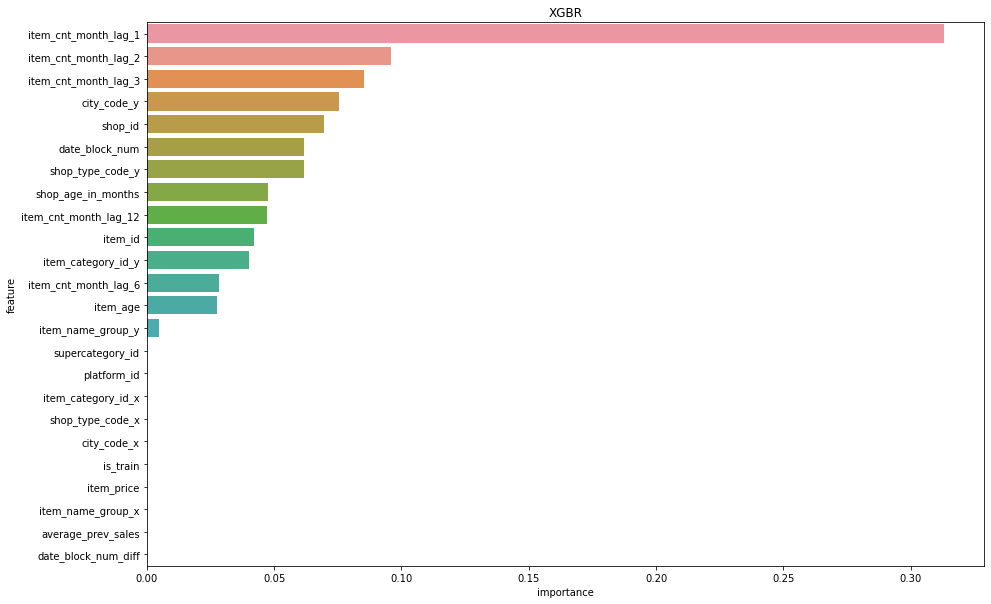

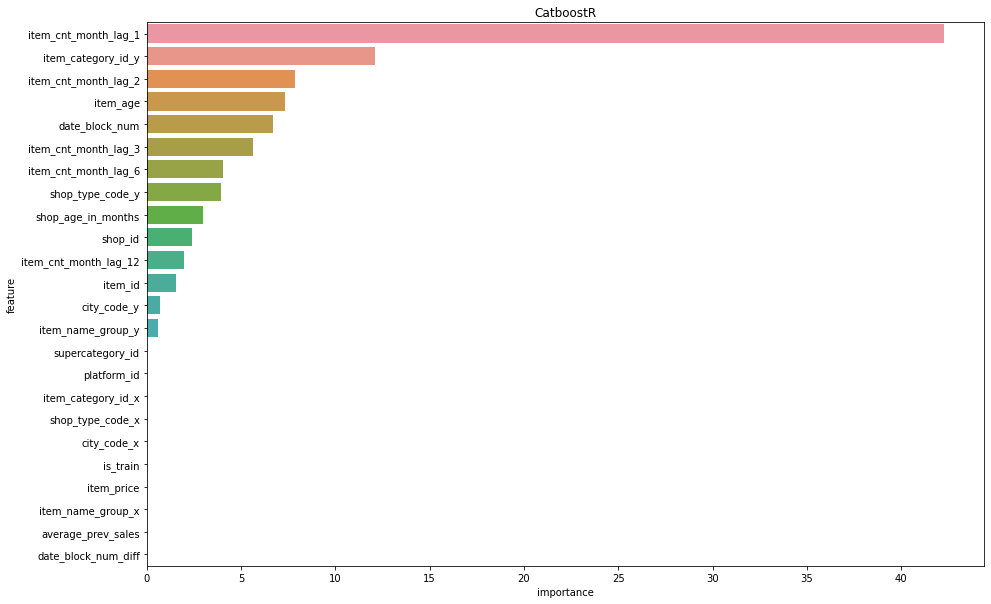

In [11]:
plot_feature_importance_layer(xgbr, train_x, 'XGBR')
plot_feature_importance_layer(catboostR, train_x, 'CatboostR')

In [12]:
del xgbr
del catboostR

### Optimization with hyperopt

In [ ]:
from hyperopt import fmin, tpe, hp, Trials
from sklearn.metrics import mean_squared_error
import time

from catboost import CatBoostRegressor
from xgboost import XGBRegressor


XGBoost_space = {'n_estimators': hp.randint('n_estimators', 100, 1000),
                 'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
                'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
                'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                'reg_alpha': hp.uniform('reg_alpha', 0, 1),
                'reg_lambda': hp.uniform('reg_lambda', 0, 1),
                'booster': hp.choice('booster', ['gbtree', 'dart']),
                'tree_method':'gpu_hist', 
                 'gpu_id':0}

Catboost_space = {'iterations': hp.randint('iterations',100,1000),
               'depth': hp.randint('depth',4,10),
               'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
               'l2_leaf_reg': hp.randint('l2_leaf_reg',1,10),
                'loss_function': 'RMSE',
               'task_type': 'GPU'}

model_type = None

def operate(params):
    if model_type == 'XGBoost':
        model = XGBRegressor(**params)
    elif model_type == 'Catboost':
        model = CatBoostRegressor(**params)
    else:
        raise ValueError(f'Invalid model type: {model_type}')
    
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    mse = mean_squared_error(test_y, y_pred)
    return {'loss': mse, 'params': params, 'status': 'ok'}

best_params=dict()
start_time = time.time()
trials = Trials()
model_type = 'XGBoost'
del trials
trials = Trials()
best_XGBoost = fmin(operate, XGBoost_space, algo=tpe.suggest, max_evals=4, trials=trials)
best_params['XGBoost'] = best_XGBoost
end_time = time.time()
elapsed_time = end_time - start_time
print('XGBoost')
print(best_params['XGBoost'])
print("XGBoost: {:.2f} seconds".format(elapsed_time))

start_time = time.time()
model_type = 'Catboost'
del trials
trials = Trials()
best_Catboost = fmin(operate, Catboost_space, algo=tpe.suggest, max_evals=10, trials=trials)
best_params['Catboost'] = best_Catboost
end_time = time.time()
elapsed_time = end_time - start_time
del trials
print('Catboost')
print(best_params['Catboost'])
print("Catboost: {:.2f} seconds".format(elapsed_time))

100%|██████████| 4/4 [06:50<00:00, 102.69s/trial, best loss: 20.144573211669922]
XGBoost
{'booster': 0, 'eta': 0.25, 'learning_rate': 0.017243201735748413, 'max_depth': 8, 'n_estimators': 459, 'reg_alpha': 0.20275084548059885, 'reg_lambda': 0.28498218455997115}

100%|██████████| 10/10 [13:30<00:00, 81.07s/trial, best loss: 19.77930069901141]
Catboost
{'depth': 6, 'iterations': 861, 'l2_leaf_reg': 8, 'learning_rate': 0.04317479764675777}
Catboost: 810.72 seconds

### Feature importance after optimization 

#### Train models

In [13]:
best_params['Catboost']['loss_function'] = 'RMSE'
best_params['Catboost']['verbose'] = 500
best_params['Catboost']['task_type'] = 'GPU'

In [14]:
CatBoostReg = CatBoostRegressor(**best_params['Catboost'])
CatBoostReg.fit(train_x, train_y)

0:	learn: 2.7260885	total: 175ms	remaining: 2m 54s
500:	learn: 1.6585009	total: 1m 11s	remaining: 1m 10s
999:	learn: 1.5742371	total: 2m 22s	remaining: 0us


In [ ]:
best_params['XGBoost']['tree_method'] = 'gpu_hist'
best_params['XGBoost']['gpu_id'] = '0'

XGBReg = XGBRegressor(**best_params['XGBoost'])
XGBReg.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.25,
             eval_metric=None, gamma=0, gpu_id='0', grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.017243201735748413, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=8, max_leaves=0,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0.20275084548059885, ...)

#### XGBoost

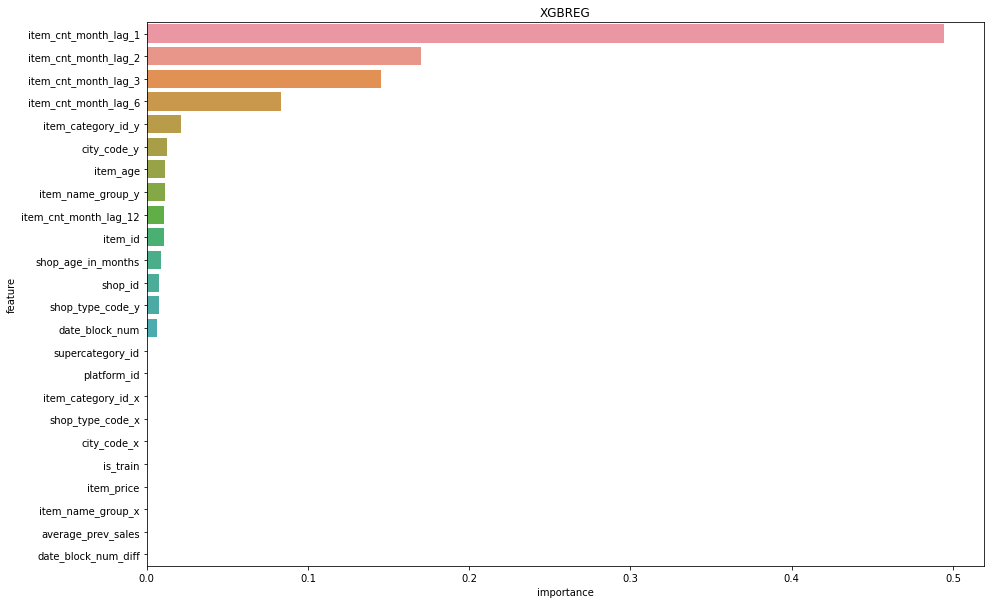

In [16]:
plot_feature_importance_layer(XGBReg, train_x, 'XGBREG')

#### Catboost

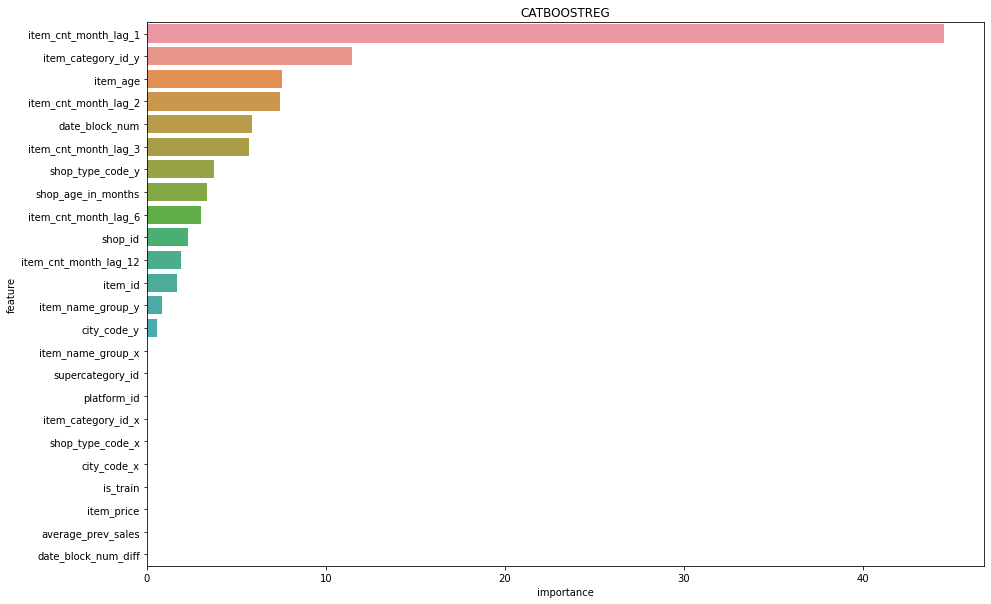

In [17]:
plot_feature_importance_layer(CatBoostReg, train_x, 'CATBOOSTREG')

### Explainability layer

In [18]:
import shap
shap.initjs()

train_x = train_x[0:20000]
train_y = train_y[0:20000]

test_x = test_x[0:20000]
test_y = test_y[0:20000]

In [19]:
def get_shap_val(model, test_x):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(test_x)
    return shap_values, explainer

In [20]:
def shap_summary_plot(test_x, shap_values):
    shap.summary_plot(shap_values, test_x)
    
def dec_plot(features_display,explainer , shap_values):
    shap.decision_plot(explainer.expected_value, shap_values, features_display)

### Error analysis layer

In [21]:
def show_infliental(shap_values, test_x, n_influential=20):
    highest_shap_indices = np.argsort(np.abs(shap_values))[-n_influential:]
    temp_df = pd.DataFrame()
    print("Samples that significantly influence the error rate:")
    for i in highest_shap_indices:
        temp_df = temp_df.append(test_x.iloc[i], ignore_index=True)
    from IPython.display import display
    display(temp_df.head(n_influential))
    del temp_df
    del highest_shap_indices

In [22]:
def rmse_operate(threshold_value, rmse):
    if rmse > threshold_value:
        print("Big target is poorly predicted.")
        print("Small dynamic is poorly predicted.")
    else:
        print("Big target is predicted well.")
        print("Small dynamic is predicted well.")
    
def get_rmse(predictions):
    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(test_y, predictions))
    return rmse

## checker

# 😼Boost

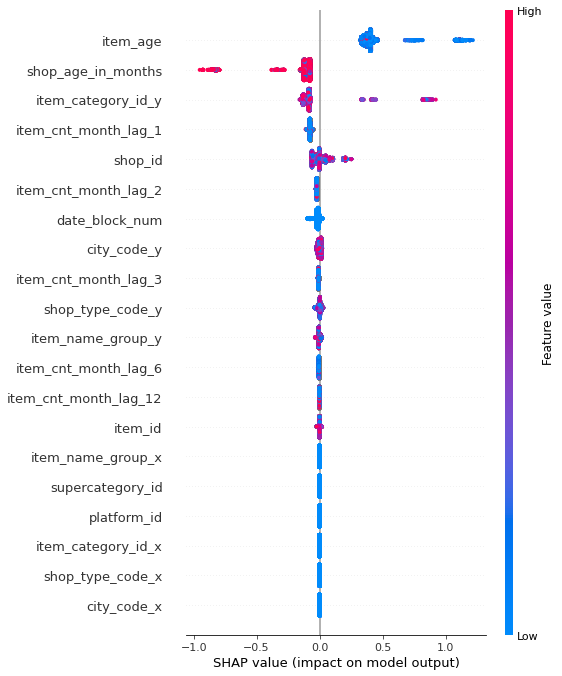

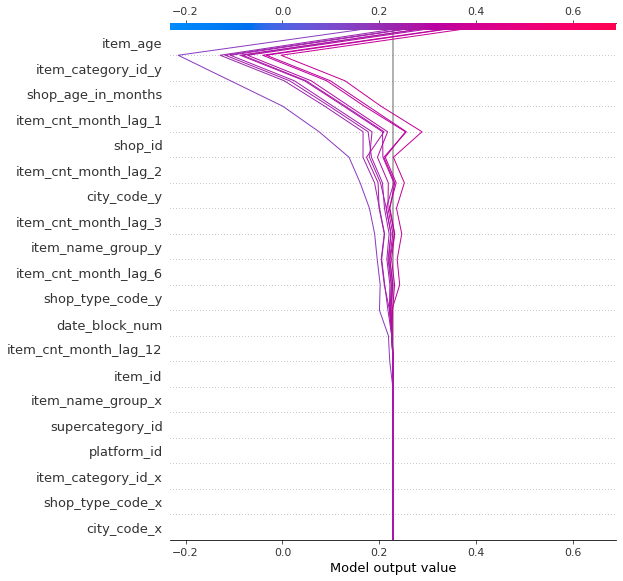

Samples that significantly influence the error rate:


,date_block_num,shop_id,item_id,item_price,is_train,city_code_x,shop_type_code_x,item_category_id_x,platform_id,supercategory_id,...,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,shop_age_in_months,average_prev_sales,item_age,city_code_y,shop_type_code_y,item_category_id_y,item_name_group_y
0,33,7,10812,0,0,0,0,0,0,0,...,NaN,NaN,NaN,33,0,2,5,3,40,5207
1,33,2,10812,0,0,0,0,0,0,0,...,NaN,NaN,NaN,33,0,2,1,1,40,5207
2,33,25,13248,0,0,0,0,0,0,0,...,0.0,NaN,NaN,33,0,5,14,2,47,6493
3,33,42,8693,0,0,0,0,0,0,0,...,NaN,NaN,NaN,33,0,2,20,5,37,4143
4,33,50,10812,0,0,0,0,0,0,0,...,NaN,NaN,NaN,33,0,2,25,1,40,5207
5,33,53,10812,0,0,0,0,0,0,0,...,NaN,NaN,NaN,33,0,2,26,1,40,5207
6,33,26,2696,0,0,0,0,0,0,0,...,1.0,3.0,NaN,33,0,6,14,1,28,1281
7,33,46,8039,0,0,0,0,0,0,0,...,NaN,NaN,NaN,33,0,2,22,1,31,3773
8,33,5,10812,0,0,0,0,0,0,0,...,NaN,NaN,NaN,32,0,2,4,3,40,5207
9,33,41,8039,0,0,0,0,0,0,0,...,NaN,NaN,NaN,33,0,2,19,1,31,3773


Big target is predicted well.
Small dynamic is predicted well.


In [23]:
shap_values, explainer = get_shap_val(CatBoostReg, train_x)
shap_summary_plot(test_x, shap_values)
dec_plot(train_x.columns, explainer, shap_values[:10])
show_infliental(shap_values, test_x)
del shap_values
del explainer

predictions = CatBoostReg.predict(test_x)
rmse = get_rmse(predictions)
del predictions
rmse_operate(25, rmse)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


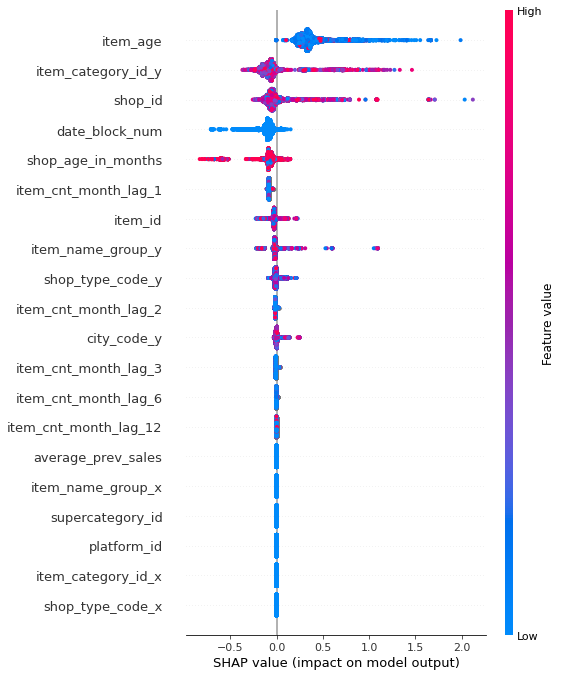

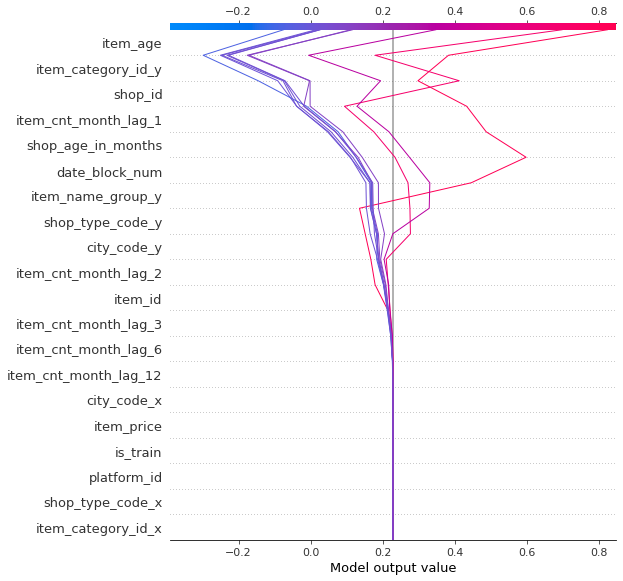

Samples that significantly influence the error rate:


,date_block_num,shop_id,item_id,item_price,is_train,city_code_x,shop_type_code_x,item_category_id_x,platform_id,supercategory_id,...,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,shop_age_in_months,average_prev_sales,item_age,city_code_y,shop_type_code_y,item_category_id_y,item_name_group_y
0,33,7,10812,0,0,0,0,0,0,0,...,NaN,NaN,NaN,33,0,2,5,3,40,5207
1,33,2,10812,0,0,0,0,0,0,0,...,NaN,NaN,NaN,33,0,2,1,1,40,5207
2,33,41,8039,0,0,0,0,0,0,0,...,NaN,NaN,NaN,33,0,2,19,1,31,3773
3,33,5,10812,0,0,0,0,0,0,0,...,NaN,NaN,NaN,32,0,2,4,3,40,5207
4,33,26,2696,0,0,0,0,0,0,0,...,1.0,3.0,NaN,33,0,6,14,1,28,1281
5,33,53,10812,0,0,0,0,0,0,0,...,NaN,NaN,NaN,33,0,2,26,1,40,5207
6,33,46,8039,0,0,0,0,0,0,0,...,NaN,NaN,NaN,33,0,2,22,1,31,3773
7,33,42,8693,0,0,0,0,0,0,0,...,NaN,NaN,NaN,33,0,2,20,5,37,4143
8,33,25,13248,0,0,0,0,0,0,0,...,0.0,NaN,NaN,33,0,5,14,2,47,6493
9,33,50,10812,0,0,0,0,0,0,0,...,NaN,NaN,NaN,33,0,2,25,1,40,5207


Big target is predicted well.
Small dynamic is predicted well.


In [24]:
shap_values, explainer = get_shap_val(XGBReg, train_x)
shap_summary_plot(test_x, shap_values)
dec_plot(train_x.columns, explainer, shap_values[:10])
show_infliental(shap_values, test_x)
del shap_values
del explainer

predictions = XGBReg.predict(test_x)
rmse = get_rmse(predictions)
del predictions
rmse_operate(25, rmse)